In [1]:
# Setup plot defaultrialsrialsrialss
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
#plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

In [2]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma)
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(data_grouped):
    initial_guess = [0.001, 0, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.06), (-0.5, 0.5), (0.001, 1)]  # Reasonable bounds

    intensities=data_grouped['delta_dur_percents'].values
    chose_test=data_grouped['num_of_chose_test'].values
    total_resp=data_grouped['total_responses'].values

    result = minimize(
        negative_log_likelihood, initial_guess, 
        args=(intensities, chose_test, total_resp),
        bounds=bounds
    )
    return result.x

# Fit psychometric function for raw data
def fit_raw_psychometric(X):
    initial_guess = [0, -.2, 0.05] # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.06), (-inf, +inf), (0.01, 0.2)]  # Reasonable bounds
    
    intensities = X['delta_dur_percents'].values
    chose_test = X['chose_test'].values
    total_resp = np.ones_like(chose_test)  # Each trial is a single observation
    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(intensities, chose_test, total_resp), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat


In [4]:
# Load data
file_path = 'data/'+'_auditory_dur_estimate_2025-01-08_16h34.13.197.csv'
#_auditory_dur_estimate_2025-01-08_16h34.13.197.csv'
#_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
data = pd.read_csv(file_path)
data['chose_test'] = (data['responses'] == data['order']).astype(int)

grouped = data.groupby(['delta_dur_percents', 'rise_dur', 'standard_dur']).agg(
    num_of_chose_test=('chose_test', 'sum'),
    total_responses=('responses', 'count'),
).reset_index()

grouped

,delta_dur_percents,rise_dur,standard_dur,num_of_chose_test,total_responses
0,-0.8,0.050,1.25,0,1
1,-0.8,0.245,1.25,0,1
2,-0.8,0.245,1.50,0,1
3,-0.7,0.050,1.75,0,1
4,-0.7,0.245,1.00,0,1
...,...,...,...,...,...
67,0.7,0.245,1.00,1,1
68,0.8,0.050,1.25,1,1
69,0.8,0.050,1.50,1,1
70,0.8,0.050,1.75,1,1


λ: 0.000, μ: -0.068, σ: 0.191
λ: 0.000, μ: 0.196, σ: 0.372
λ: 0.000, μ: 0.023, σ: 0.283
λ: 0.060, μ: 0.500, σ: 0.001
λ: 0.000, μ: 0.158, σ: 0.264
λ: 0.000, μ: 0.291, σ: 0.260
λ: 0.000, μ: -0.055, σ: 0.019
λ: 0.000, μ: 0.155, σ: 0.120


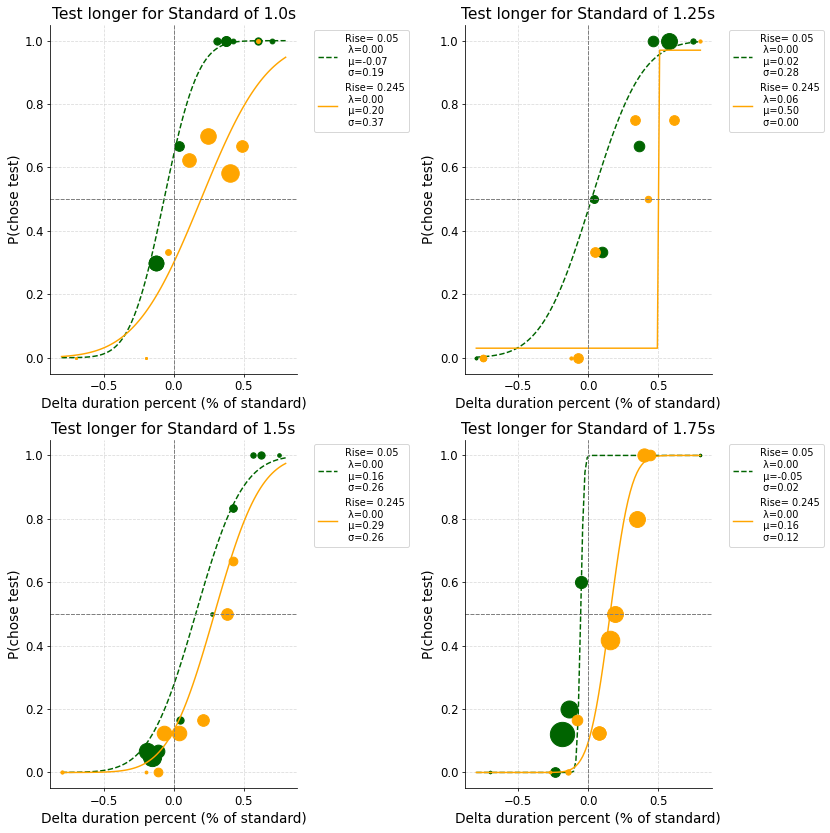

In [60]:
def plot_psychometric_functions(data):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    #sort the data by standard duration
    data = data.sort_values(by='standard_dur')
    for k, i in enumerate(data['standard_dur'].unique()):
        # Filter data by standard duration
        data_by_standard = data[data['standard_dur'] == i].copy()
        # take the choose test column if  response is equal to test order
        data_by_standard.loc[:, 'chose_test'] = (data_by_standard['responses'] == data_by_standard['order']).astype(int)


        aggregated_data = data_by_standard.groupby(['delta_dur_percents', 'rise_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
        aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']
        # sort the values
        aggregated_data = aggregated_data.sort_values(by='rise_dur')
        
        for j in aggregated_data['rise_dur'].unique():
            lineStyle = '--' if j == 0.050 else '-'  # Different line style for rise_dur=0.050
            lineColor = 'darkgreen' if j == 0.050 else 'orange'  # Different line color for rise_dur=0.050

            Y = aggregated_data[aggregated_data['rise_dur'] == j]
            lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(Y)
            print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = Y['delta_dur_percents']
            y_data = Y['p_choose_test']
            
            # bin_edges = np.histogram_bin_edges(x_data, bins=3)
            # bin_centers = (bin_edges[:-1] + bin_edges[1:]) // 2
            # y_data_binned = np.zeros(len(bin_centers))
            # bin_sizes = np.zeros(len(bin_centers))
            # for m in range(len(bin_centers)):
            #     bin_mask = (x_data >= bin_edges[m]) & (x_data < bin_edges[m + 1])
            #     y_data_binned[m] = y_data[bin_mask].mean()
            #     bin_sizes[m] = bin_mask.sum()
            # y_data_smooth_binned = pd.Series(y_data_binned)
            
            # # Normalize bin sizes for scatter plot
            # bin_sizes_normalized = bin_sizes / bin_sizes.max() * 100
            ax = axs[k // 2, k % 2]
            # ax.scatter(bin_centers, y_data_smooth_binned, s=bin_sizes_normalized, alpha=0.3)

            X=Y
            X=X.sort_values(by='delta_dur_percents')
            bin_size=10
            x_data=X['delta_dur_percents']
            y_data=X['p_choose_test']
            total_bins=X['total_responses']

            # for m in range(len(x_data)):
            #     ax.plot(np.mean(x_data[m-bin_size:m+bin_size]),np.mean(y_data[m:m+bin_size]),'o', 
            #             markersize=np.sum(total_bins[m:m+bin_size])/np.sum(total_bins)*10,color=lineColor)
            for m in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),10):
                    # search for values +- 0.2 of the i value
                    mask=(x_data>=m-0.2) & (x_data<m+0.2)
                    # get the mean of the values
                    x_mean=np.mean(x_data[mask])
                    y_mean=np.mean(y_data[mask])
                    # get the total responses
                    total_resp=np.sum(total_bins[mask])
                    # plot the mean values
                    ax.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color=lineColor)
                    
            #ax.scatter(bin_centers, y_data_smooth_binned, alpha=0.3)
            #ax.scatter(x_data,y_data)
            x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
            ax.plot(x_fit, y_fit, linestyle=lineStyle, color=lineColor, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Delta duration percent (% of standard)')
            ax.set_ylabel('P(chose test)')
            ax.set_title(f'Test longer for Standard of {i}s')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            # remove axspines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Call the function
plot_psychometric_functions(data)

# Pool data across standard durations

,delta_dur_percents,rise_dur,num_of_chose_test,total_responses,p_choose_test
0,-0.8,0.245,0,2,0.0
1,-0.7,0.245,0,2,0.0


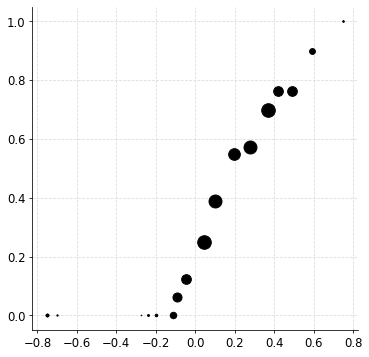

In [40]:
data_by_rise.loc[:, 'chose_test'] = (data_by_rise['responses'] == data_by_rise['order']).astype(int)


aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'rise_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

# sort the values
aggregated_data = aggregated_data.sort_values(by='rise_dur')
lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(aggregated_data)

X=aggregated_data
x_bins=np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']))
X=X.sort_values(by='delta_dur_percents')
bin_size=5
x_data=X['delta_dur_percents']
y_data=X['p_choose_test']
total_bins=X['total_responses']

#for idx_data, delta in enumerate(X['delta_dur_percents']):

for i in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),20):
    # search for values +- 0.2 of the i value
    mask=(x_data>=i-0.2) & (x_data<i+0.2)
    # get the mean of the values
    x_mean=np.mean(x_data[mask])
    y_mean=np.mean(y_data[mask])
    # get the total responses
    total_resp=np.sum(total_bins[mask])
    # plot the mean values
    plt.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color='k')
    #plt.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*10,color='k')

# for i in range(len(x_data)):
#     plt.plot(np.mean(x_data[i-bin_size:i+bin_size]),np.mean(y_data[i:i+bin_size]),'o', 
#              markersize=np.sum(total_bins[i:i+bin_size])/np.sum(total_bins)*30,color='k')
    

X[:2]


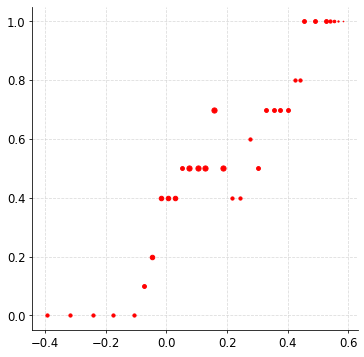

In [ ]:
def plot_binned_data(X,bin_size=5,color='k'):# X should be grouped data
    X=X.sort_values(by='delta_dur_percents')
    x_data=X['delta_dur_percents']
    y_data=X['p_choose_test']
    total_bins=X['total_responses']
    x_bins=np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),15)
    for i in range(len(x_data)):
        plt.plot(np.mean(x_data[i-bin_size:i+bin_size]),np.mean(y_data[i:i+bin_size]),'o', 
                markersize=np.sum(total_bins[i:i+bin_size])/np.sum(total_bins)*30,color=color)

data = data.sort_values(by='standard_dur')
data_by_rise = data[data['rise_dur'] == 0.245].copy()
data_by_rise=data_by_rise.sort_values(by='rise_dur')    
aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'standard_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

plot_binned_data(aggregated_data,bin_size=5,color='r')


# Functions to pool data across standard durations

In [19]:
def data_grouped_standard(data,rise_cond,standard_dur):
    data = data.sort_values(by='standard_dur')
    data_by_rise = data[data['rise_dur'] == rise_cond].copy()
    
    aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'standard_dur']).agg(
                    num_of_chose_test=('chose_test', 'sum'),
                    total_responses=('responses', 'count'),
            ).reset_index()
    aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

    # sort the values
    aggregated_data = aggregated_data.sort_values(by='standard_dur')
    aggregated_data = aggregated_data[aggregated_data['standard_dur'] == standard_dur].copy()

    return aggregated_data

a=data_grouped_standard(data,0.05,1)
a[:2]

,delta_dur_percents,standard_dur,num_of_chose_test,total_responses,p_choose_test
8,-0.1625,1.0,0,1,0.0
19,0.2750,1.0,2,2,1.0


λ: 0.000, μ: 0.229, σ: 0.246
λ: 0.000, μ: 0.229, σ: 0.246
λ: 0.000, μ: 0.229, σ: 0.246
λ: 0.000, μ: 0.229, σ: 0.246
λ: 0.000, μ: 0.036, σ: 0.238
λ: 0.000, μ: 0.036, σ: 0.238
λ: 0.000, μ: 0.036, σ: 0.238
λ: 0.000, μ: 0.036, σ: 0.238


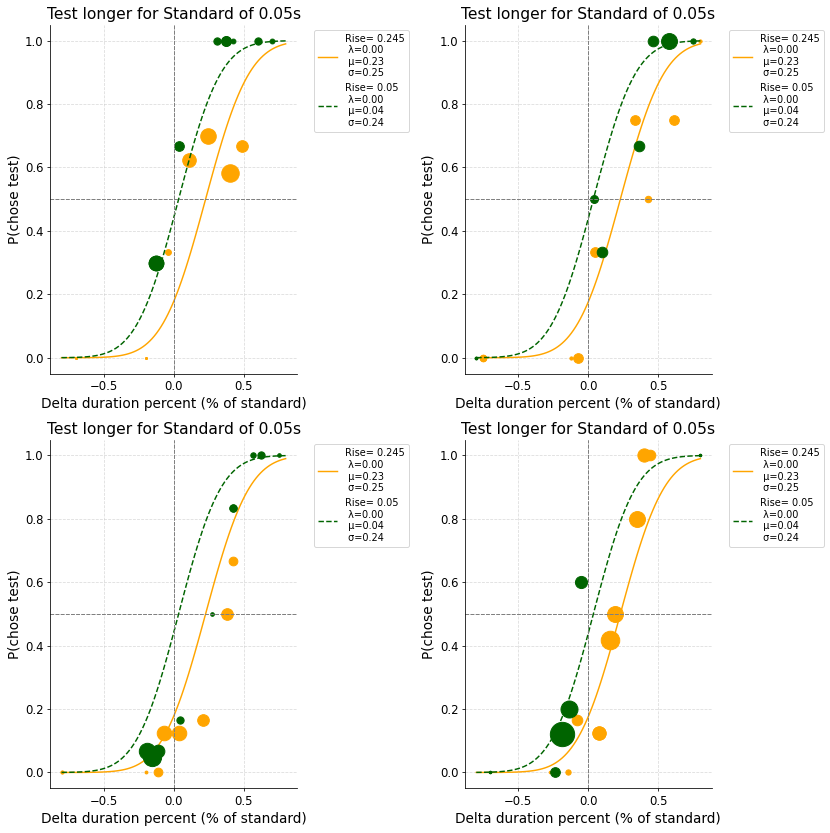

In [59]:
# TODO: First group by rise duration pool the data across the standard durations fit psychometric function take the lambda mu sigma parameters and then 
# plot seperately for each standard durations

def plot_psychometric_functions(data):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    #sort the data by standard duration
    data = data.sort_values(by='standard_dur')
    
    for k, i in enumerate(data['rise_dur'].unique()):
        # Filter data by standard duration
        data_by_rise = data[data['rise_dur'] == i].copy()
        # take the choose test column if  response is equal to test order
        data_by_rise.loc[:, 'chose_test'] = (data_by_rise['responses'] == data_by_rise['order']).astype(int)


        aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'standard_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
        aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

        # sort the values
        aggregated_data = aggregated_data.sort_values(by='standard_dur')
        lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(aggregated_data)

        for idx_data, j in enumerate(aggregated_data['standard_dur'].unique()):
            lineStyle = '--' if i == 0.050 else '-'  # Different line style for rise_dur=0.050
            lineColor = 'darkgreen' if i == 0.050 else 'orange'  # Different line color for rise_dur=0.050

            Y = aggregated_data[aggregated_data['standard_dur'] == j]
            print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = Y['delta_dur_percents']
            y_data = Y['p_choose_test']
            

            ax = axs[idx_data // 2, idx_data % 2]
            # ax.scatter(bin_centers, y_data_smooth_binned, s=bin_sizes_normalized, alpha=0.3)

            #ax.scatter(bin_centers, y_data_smooth_binned, alpha=0.3)
            X=data_grouped_standard(data,i,j)
            X=X.sort_values(by='delta_dur_percents')
            bin_size=3
            x_data=X['delta_dur_percents']
            y_data=X['p_choose_test']
            total_bins=X['total_responses']

            # # for m in range(len(x_data)):
            # #     ax.plot(np.mean(x_data[m-bin_size:m+bin_size]),np.mean(y_data[m:m+bin_size]),'o', 
            # #             markersize=np.sum(total_bins[m:m+bin_size])/np.sum(total_bins)*30,color=lineColor)

            for m in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),10):
                # search for values +- 0.2 of the i value
                mask=(x_data>=m-0.2) & (x_data<m+0.2)
                # get the mean of the values
                x_mean=np.mean(x_data[mask])
                y_mean=np.mean(y_data[mask])
                # get the total responses
                total_resp=np.sum(total_bins[mask])
                # plot the mean values
                ax.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color=lineColor)
                
            #ax.scatter(x_data,y_data)
            x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
            ax.plot(x_fit, y_fit, linestyle=lineStyle, color=lineColor, label=f'Rise= {i}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Delta duration percent (% of standard)')
            ax.set_ylabel('P(chose test)')
            ax.set_title(f'Test longer for Standard of {i}s')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            # remove axspines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Call the function
plot_psychometric_functions(data)

## Bootstrap

In [21]:
# Fit the psychometric function to the original data
lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(grouped)

# Original parameter values
print(f"Original Fit: λ = {lambda_hat}, μ = {mu_hat}, σ = {sigma_hat}")



Original Fit: λ = 0.0, μ = 0.13791479330783685, σ = 0.2880154684694731


#### 2. Simulating Bootstrap Data python Copy code

In [189]:
# Generate a single parametric bootstrap dataset
def generate_parametric_bootstrap(original_data):
    simulated_data = original_data.copy()
    lambda_, mu_, sigma_ = fit_psychometric_function(original_data)

    for idx, row in simulated_data.iterrows():
        x = row['delta_dur_percents']
        n_trials = row['total_responses']
        
        # Compute the probability of "chose test" using the psychometric function
        p = psychometric_function(x, lambda_, mu_, sigma_)
        
        # Simulate responses as binomial random draws
        simulated_responses = np.random.binomial(n=n_trials, p=p)
        simulated_data.at[idx, 'num_of_chose_test'] = simulated_responses
    
    return simulated_data


#### 3. Bootstrapping the fit

In [190]:

def full_bootstraping(data, n_bootstrap):
    bootstrap_fits = []
    bootstraps=[]
    for _ in range(n_bootstrap):
        # Generate a bootstrap dataset
        bootstrap_data = generate_parametric_bootstrap(data)
        bootstraps.append(bootstrap_data)
        # Re-fit the psychometric function to the bootstrap data
        lambda_, mu_, sigma_ = fit_psychometric_function(bootstrap_data)        

        bootstrap_fits.append([lambda_, mu_, sigma_])
    bootstrap_fits = pd.DataFrame(bootstrap_fits, columns=['lambda', 'mu', 'sigma'])
    bootstraps = pd.concat(bootstraps)
    return bootstrap_fits, bootstraps

bootstrap_fits, bootstraps = full_bootstraping(grouped, 100)

#### 4. Analyzing Bootstrap Results


λ 95% CI: [0.   0.06]
μ 95% CI: [0.05396511 0.22585411]
σ 95% CI: [0.1310139  0.40218703]


Text(0.5, 1.0, 'σ')

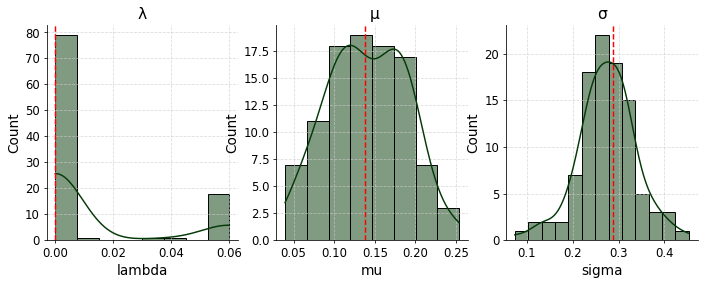

In [191]:
# Calculate 95% confidence intervals for each parameter
lambda_ci = np.percentile(bootstrap_fits['lambda'], [2.5, 97.5])
mu_ci = np.percentile(bootstrap_fits['mu'], [2.5, 97.5])
sigma_ci = np.percentile(bootstrap_fits['sigma'], [2.5, 97.5])

print(f"λ 95% CI: {lambda_ci}")
print(f"μ 95% CI: {mu_ci}")
print(f"σ 95% CI: {sigma_ci}")

# Plot the bootstrap distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(bootstrap_fits['lambda'], kde=True)
plt.axvline(lambda_hat, color='red', linestyle='--')
plt.title('λ')

plt.subplot(1, 3, 2)
sns.histplot(bootstrap_fits['mu'], kde=True)
plt.axvline(mu_hat, color='red', linestyle='--')
plt.title(' μ')

plt.subplot(1, 3, 3)
sns.histplot(bootstrap_fits['sigma'], kde=True)
plt.axvline(sigma_hat, color='red', linestyle='--')
plt.title('σ')


λ: 0.002, μ: 0.028, σ: 0.282
λ: 0.060, μ: 0.500, σ: 0.001
λ: 0.000, μ: 0.290, σ: 0.261
λ: 0.000, μ: 0.159, σ: 0.265
λ: 0.000, μ: -0.055, σ: 0.020
λ: 0.000, μ: 0.157, σ: 0.118
λ: 0.012, μ: 0.197, σ: 0.364
λ: 0.000, μ: -0.068, σ: 0.189


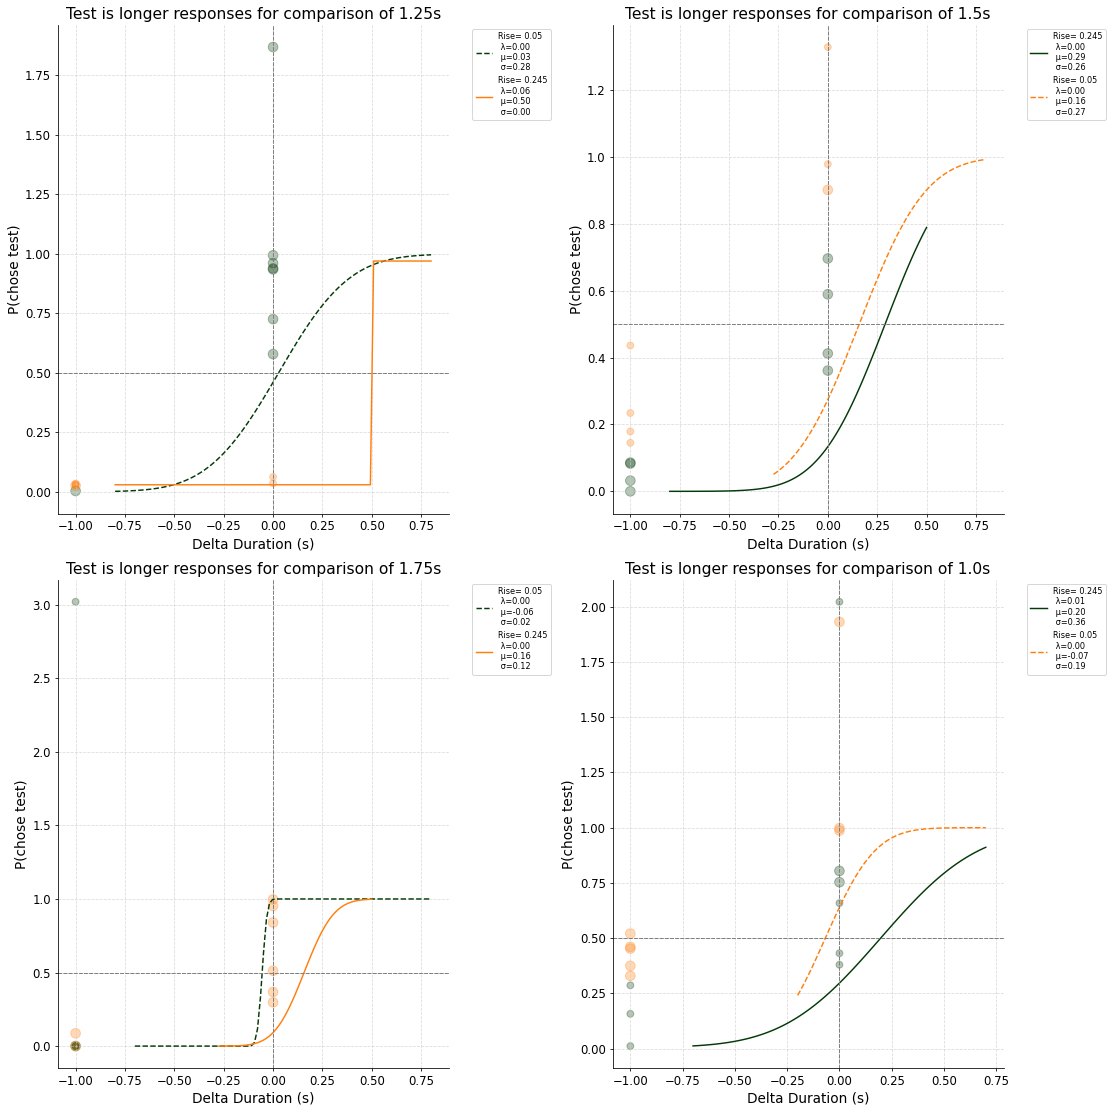

In [192]:
def pregrouped_plot_psychometric_functions(data):
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))

    for k, i in enumerate(data['standard_dur'].unique()):
        # Filter data by standard duration
        data_by_standard = data[data['standard_dur'] == i].copy()

        # Plot psychometric functions
        for j in data_by_standard['rise_dur'].unique():
            lineStyle = '--' if j == 0.050 else '-'

            data_by_standard_and_rise = data_by_standard[data_by_standard['rise_dur'] == j]

            # bootstrap Y
            y_bootstrap_fits, y_bootstraps = full_bootstraping(data_by_standard_and_rise, 1000)

            lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(y_bootstraps)
            print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = y_bootstraps['delta_dur_percents']
            y_data = y_bootstraps['num_of_chose_test']
            bin_edges = np.histogram_bin_edges(x_data, bins=30)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) // 2
            y_data_binned = np.zeros(len(bin_centers))
            bin_sizes = np.zeros(len(bin_centers))
            for m in range(len(bin_centers)):
                bin_mask = (x_data >= bin_edges[m]) & (x_data < bin_edges[m + 1])
                y_data_binned[m] = y_data[bin_mask].mean()
                bin_sizes[m] = bin_mask.sum()
            y_data_smooth_binned = pd.Series(y_data_binned)
            
            # Normalize bin sizes for scatter plot
            bin_sizes_normalized = bin_sizes / bin_sizes.max() * 100
            ax = axs[k // 2, k % 2]
            ax.scatter(bin_centers, y_data_smooth_binned, s=bin_sizes_normalized, alpha=0.3)

            x_fit = np.linspace(min(y_bootstraps['delta_dur_percents']), max(y_bootstraps['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)

            ax.plot(x_fit, y_fit, linestyle=lineStyle, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Delta Duration (s)')
            ax.set_ylabel('P(chose test)')
            ax.set_title(f'Test is longer responses for comparison of {i}s')
            
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            # remove axspines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
    plt.tight_layout()
    plt.show()

pregrouped_plot_psychometric_functions(grouped)